In [ ]:
 # Code is still work in progress
!pip install yfinance


In [ ]:
import numpy as np
import math
import time

class OptionPricing:

	def __init__(self,S0,E,T,rf,sigma,iterations):
		self.S0 = S0
		self.E = E
		self.T = T
		self.rf = rf
		self.sigma = sigma
		self.iterations = iterations

	def call_option_simulation(self):

		#we have 2 columns: first with 0s the second column will store the payoff
		#we need the first column of 0s: payoff function is max(0,S-E) for call option
		option_data = np.zeros([self.iterations, 2])

		#dimensions: 1 dimensional array with as many items as the itrations
		rand = np.random.normal(0, 1, [1, self.iterations])

		#equation for the S(t) stock price
		stock_price = self.S0*np.exp(self.T*(self.rf - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.T)*rand)

		#we need S-E because we have to calculate the max(S-E,0)
		option_data[:,1] = stock_price - self.E

		#average for the Monte-Carlo method
		#np.amax() returns the max(0,S-E) according to the formula
		average = np.sum(np.amax(option_data, axis=1))/float(self.iterations)

		#have to use the exp(-rT) discount factor
		return np.exp(-1.0*self.rf*self.T)*average

	def put_option_simulation(self):

		#we have 2 columns: first with 0s the second column will store the payoff
		#we need the first column of 0s: payoff function is max(0,E-S) for put option
		option_data = np.zeros([self.iterations, 2])

		#dimensions: 1 dimensional array with as many items as the itrations
		rand = np.random.normal(0, 1, [1, self.iterations])

		#equation for the S(t) stock price
		stock_price = self.S0*np.exp(self.T*(self.rf - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.T)*rand)

		#we need E-S because we have to calculate the max(E-S,0)
		option_data[:,1] = self.E - stock_price

		#average for the Monte-Carlo method
		#np.amax() returns the max(0,E-S) according to the formula
		average = np.sum(np.amax(option_data, axis=1))/float(self.iterations)

		#have to use the exp(-rT) discount factor
		return np.exp(-1.0*self.rf*self.T)*average

if __name__ == "__main__":

	S0=100					#underlying stock price at t=0
	E=100					#strike price
	T = 1					#expiry
	rf = 0.05				#risk-free rate
	sigma=0.2				#volatility of the underlying stock
	iterations = 1000000	#number of iterations in the Monte-Carlo simulation

	model = OptionPricing(S0,E,T,rf,sigma,iterations)
	print("Call option price with Monte-Carlo approach: ", model.call_option_simulation())
	print("Put option price with Monte-Carlo approach: ", model.put_option_simulation())

Call option price with Monte-Carlo approach:  10.452380838355728
Put option price with Monte-Carlo approach:  5.571659554382485


Base Market Value: 17179026.73
Agg Duration: 4.5972
Agg Convexity: 30.6484
Portfolio DV01: -8173.14

Scenario results:
                  scenario       base_mv     bumped_mv      pv_change  \
0            parallel_50bp  1.717903e+07  1.677576e+07 -403262.213162   
1           parallel_-50bp  1.717903e+07  1.759341e+07  414381.923385   
2  twist_short0bp_long50bp  1.717903e+07           NaN -401577.898634   

   pv_change_pct    twisted_mv  
0      -0.023474           NaN  
1       0.024121           NaN  
2      -0.023376  1.677745e+07  

Saved scenario_results.csv
Saved pv_changes.png

Monte Carlo (Vasicek) results:
Mean MV: 17594182.709907133 Std MV: 864506.973705521
Saved mc_portfolio_values.csv
Saved mc_hist.png

Done. Inspect output csv/png files for a quick report.


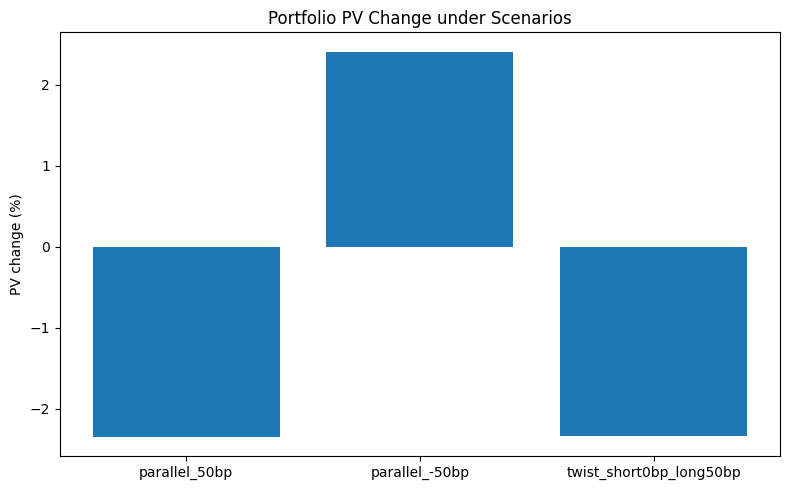

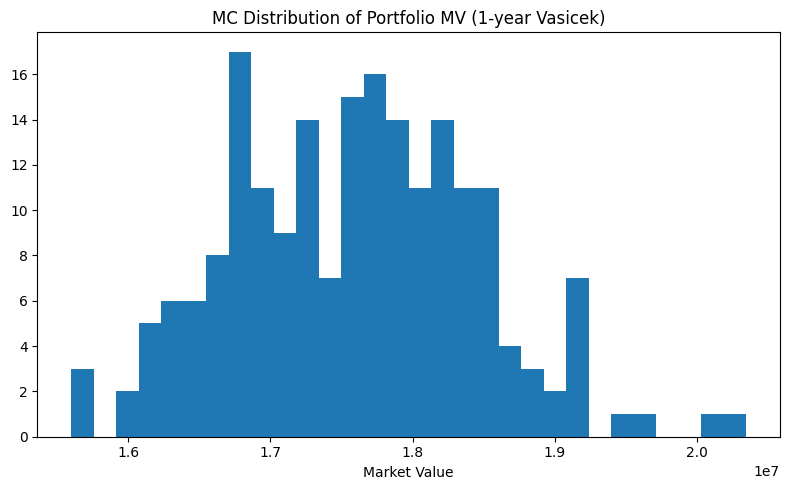

In [ ]:


from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# -----------------------------
# Utilities
# -----------------------------

def year_fraction(start: datetime, end: datetime) -> float:
    """Simple ACT/365 year fraction."""
    return (end - start).days / 365.0


# -----------------------------
# Term structure (yield curve) helper
# -----------------------------
class YieldCurve:
    """
    Simple term-structure object. Accepts either a flat rate or a set of (tenor_years -> rate) points.
    Interpolates linearly in year space.
    Rates are assumed continuously-compounded for pricing convenience; input may be treated as
    annual coupon-equivalent and converted as needed.
    """
    def __init__(self, points: Optional[Dict[float, float]] = None, flat_rate: Optional[float] = None):
        if flat_rate is None and (points is None or len(points) == 0):
            raise ValueError("Either flat_rate or points must be provided")
        if flat_rate is not None:
            self.flat = True
            self.r = float(flat_rate)
            self._interp = None
        else:
            self.flat = False
            # points: tenor_years -> rate (annual continuously-compounded)
            xs = np.array(sorted(points.keys()))
            ys = np.array([points[x] for x in xs])
            self._interp = interp1d(xs, ys, kind='linear', fill_value='extrapolate')

    def rate(self, t: float) -> float:
        """Return instantaneous continuously-compounded rate for tenor t (years)."""
        if self.flat:
            return self.r
        return float(self._interp(t))

    def discount_factor(self, t: float) -> float:
        r = self.rate(t)
        return math.exp(-r * t)


# -----------------------------
# Bond representation
# -----------------------------
@dataclass
class Bond:
    name: str
    face: float
    coupon_rate: float  # annual coupon rate (e.g., 0.05 for 5%)
    maturity_date: datetime
    coupon_freq: int = 2  # semiannual by default
    issue_date: Optional[datetime] = None
    is_zero: bool = False

    def cashflows(self, as_of: datetime) -> List[Tuple[datetime, float]]:
        """Return list of (date, amount) cashflows after as_of (exclusive of as_of)."""
        start = self.issue_date or as_of
        payments = []
        if self.is_zero:
            if self.maturity_date > as_of:
                payments.append((self.maturity_date, self.face))
            return payments

        # generate coupon schedule from as_of to maturity
        period = 12 // self.coupon_freq
        # find next coupon date after as_of
        cur = self.maturity_date
        # build backwards then reverse
        dates = [self.maturity_date]
        while True:
            cur = cur - timedelta(days=period * 30)  # approximate month by 30 days for schedule
            if cur <= as_of:
                break
            dates.append(cur)
            # safety
            if len(dates) > 1000:
                break
        dates = sorted(dates)
        for d in dates[:-1]:
            coupon = self.face * self.coupon_rate / self.coupon_freq
            payments.append((d, coupon))
        # last payment includes principal
        if dates:
            last = dates[-1]
            coupon = self.face * self.coupon_rate / self.coupon_freq
            payments.append((last, coupon + self.face))
        return payments

    def clean_price(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        """
        Price calculated by discounting cashflows. If curve is provided -> discount using curve rates
        (term-structure). If ytm provided -> use flat yield to maturity to discount.
        Returns clean price (ex-coupon approximation).
        """
        cfs = self.cashflows(as_of)
        pv = 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve is not None:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve is required")
            pv += amt * df
        return pv

    def macaulay_duration(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv = 0.0
        weighted = 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve is not None:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve is required")
            pv_cf = amt * df
            pv += pv_cf
            weighted += t * pv_cf
        if pv == 0:
            return 0.0
        return weighted / pv

    def modified_duration(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        mac = self.macaulay_duration(as_of, ytm=ytm, curve=curve)
        # use approximate yield for conversion: if ytm provided, use it; otherwise use curve rate at maturity
        if ytm is not None:
            y = ytm
        else:
            T = year_fraction(as_of, self.maturity_date)
            y = curve.rate(T)
        return mac / (1 + y)

    def convexity(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv = 0.0
        conv = 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve is not None:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve is required")
            pv_cf = amt * df
            pv += pv_cf
            conv += t * (t + 1) * pv_cf  # approximate continuous -> use t*(t+1)
        if pv == 0:
            return 0.0
        return conv / pv

    def dv01(self, as_of: datetime, bump: float = 1e-4, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        base = self.clean_price(as_of, ytm=ytm, curve=curve)
        # bump methodology: parallel shift by bump
        if curve is not None:
            # create bumped curve by shifting rates up by bump
            if curve.flat:
                bumped = YieldCurve(flat_rate=curve.r + bump)
            else:
                # sample a few tenors and shift
                # reconstruct points by sampling at relevant tenors
                # for simplicity, we shift function by bump
                class _Shifted:
                    def __init__(self, c, shift):
                        self.c = c
                        self.shift = shift
                        self.flat = False
                    def rate(self, t):
                        return self.c.rate(t) + self.shift
                    def discount_factor(self, t):
                        return math.exp(-(self.c.rate(t) + self.shift) * t)
                bumped = _Shifted(curve, bump)
        else:
            bumped = None
        bumped_price = self.clean_price(as_of, ytm=(ytm + bump) if ytm is not None else None, curve=(bumped if curve is not None else None))
        return bumped_price - base


# -----------------------------
# Portfolio container
# -----------------------------
@dataclass
class Portfolio:
    bonds: List[Tuple[Bond, float]] = field(default_factory=list)  # list of (Bond, position notional)

    def market_value(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        s = 0.0
        for bond, notional in self.bonds:
            price = bond.clean_price(as_of, ytm=ytm, curve=curve)
            s += price * (notional / bond.face)
        return s

    def aggregate_duration_convexity(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> Dict[str, float]:
        mv = self.market_value(as_of, ytm=ytm, curve=curve)
        dur_w = 0.0
        conv_w = 0.0
        for bond, notional in self.bonds:
            price = bond.clean_price(as_of, ytm=ytm, curve=curve)
            pos_mv = price * (notional / bond.face)
            d = bond.modified_duration(as_of, ytm=ytm, curve=curve)
            c = bond.convexity(as_of, ytm=ytm, curve=curve)
            dur_w += d * pos_mv
            conv_w += c * pos_mv
        if mv == 0:
            return {"duration": 0.0, "convexity": 0.0}
        return {"duration": dur_w / mv, "convexity": conv_w / mv}

    def dv01(self, as_of: datetime, bump: float = 1e-4, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        base = self.market_value(as_of, ytm=ytm, curve=curve)
        # build bumped curve or ytm
        if curve is not None:
            if curve.flat:
                bumped_curve = YieldCurve(flat_rate=curve.r + bump)
            else:
                class _Shifted:
                    def __init__(self, c, shift):
                        self.c = c
                        self.shift = shift
                        self.flat = False
                    def rate(self, t):
                        return self.c.rate(t) + self.shift
                    def discount_factor(self, t):
                        return math.exp(-(self.c.rate(t) + self.shift) * t)
                bumped_curve = _Shifted(curve, bump)
            bumped = self.market_value(as_of, ytm=None, curve=bumped_curve)
        else:
            bumped = self.market_value(as_of, ytm=ytm + bump, curve=None)
        return bumped - base


# -----------------------------
# Scenario engine
# -----------------------------
class ScenarioEngine:
    def __init__(self, base_curve: YieldCurve, as_of: datetime):
        self.base_curve = base_curve
        self.as_of = as_of

    def parallel_shift(self, portfolio: Portfolio, shift_bp: float) -> Dict:
        shift = shift_bp / 10000.0
        if self.base_curve.flat:
            bumped = YieldCurve(flat_rate=self.base_curve.r + shift)
        else:
            # for term structure, we'll shift the whole curve up by shift
            class _Shifted:
                def __init__(self, c, shift):
                    self.c = c
                    self.shift = shift
                    self.flat = False
                def rate(self, t):
                    return self.c.rate(t) + self.shift
                def discount_factor(self, t):
                    return math.exp(-(self.c.rate(t) + self.shift) * t)
            bumped = _Shifted(self.base_curve, shift)
        base_mv = portfolio.market_value(self.as_of, curve=self.base_curve)
        bumped_mv = portfolio.market_value(self.as_of, curve=bumped)
        return {
            "scenario": f"parallel_{shift_bp}bp",
            "base_mv": base_mv,
            "bumped_mv": bumped_mv,
            "pv_change": bumped_mv - base_mv,
            "pv_change_pct": (bumped_mv - base_mv) / base_mv if base_mv != 0 else 0.0
        }

    def steepen_flatten(self, portfolio: Portfolio, short_shift_bp: float, long_shift_bp: float, pivot_year: float = 2.0) -> Dict:
        """
        Steepening: long end up by long_shift_bp, short end up by short_shift_bp (could be negative)
        We implement a linear interpolation between short (0) and long (pivot_year to 30) adjustments.
        """
        s_shift = short_shift_bp / 10000.0
        l_shift = long_shift_bp / 10000.0

        class _Twist:
            def __init__(self, c, s_shift, l_shift, pivot):
                self.c = c
                self.s_shift = s_shift
                self.l_shift = l_shift
                self.pivot = pivot
                self.flat = False
            def rate(self, t):
                # decide factor between 0..1 based on t
                if t <= 0:
                    factor = 0.0
                else:
                    factor = min(1.0, t / self.pivot)
                return self.c.rate(t) + (1 - factor) * self.s_shift + factor * self.l_shift
            def discount_factor(self, t):
                return math.exp(-self.rate(t) * t)

        twisted = _Twist(self.base_curve, s_shift, l_shift, pivot_year)
        base_mv = portfolio.market_value(self.as_of, curve=self.base_curve)
        twisted_mv = portfolio.market_value(self.as_of, curve=twisted)
        return {
            "scenario": f"twist_short{short_shift_bp}bp_long{long_shift_bp}bp",
            "base_mv": base_mv,
            "twisted_mv": twisted_mv,
            "pv_change": twisted_mv - base_mv,
            "pv_change_pct": (twisted_mv - base_mv) / base_mv if base_mv != 0 else 0.0
        }


# -----------------------------
# Vasicek short-rate model -> simple yield curve simulation (for demo)
# -----------------------------
class VasicekSimulator:
    """
    Vasicek model applied to short-term rate and projecting zero-coupon yields approximately.
    This is a demonstrative Monte Carlo; more sophisticated HJM or multifactor models would be needed
    for production-quality term structure simulation.
    """
    def __init__(self, r0: float, kappa: float, theta: float, sigma: float, dt: float = 1/252):
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.dt = dt

    def simulate_paths(self, n_paths: int, n_steps: int) -> np.ndarray:
        paths = np.zeros((n_paths, n_steps + 1))
        paths[:, 0] = self.r0
        for t in range(1, n_steps + 1):
            z = np.random.normal(size=n_paths)
            dr = self.kappa * (self.theta - paths[:, t-1]) * self.dt + self.sigma * np.sqrt(self.dt) * z
            paths[:, t] = paths[:, t-1] + dr
        return paths

    def short_rate_to_zero_rate(self, r_short: float, T: float) -> float:
        """
        Heuristic: convert short rate to an approximate zero rate for tenor T by simple mean-reversion adjustment.
        This is a crude approximation but fine for demo Monte Carlo sensitivity.
        """
        return r_short  # naive


# -----------------------------
# Example run & plotting
# -----------------------------
if __name__ == '__main__':
    today = datetime.today()

    # Build a simple term structure (example points in years -> continuously compounded rates)
    points = {
        0.25: 0.025,
        0.5: 0.027,
        1.0: 0.03,
        2.0: 0.032,
        5.0: 0.035,
        10.0: 0.037
    }
    base_curve = YieldCurve(points=points)

    # Create some sample bonds
    b1 = Bond(name='UST_5Y', face=1000, coupon_rate=0.03, maturity_date=today + timedelta(days=int(5*365)), coupon_freq=2, issue_date=today - timedelta(days=30))
    b2 = Bond(name='CORP_7Y', face=1000, coupon_rate=0.045, maturity_date=today + timedelta(days=int(7*365)), coupon_freq=2, issue_date=today - timedelta(days=30))
    b3 = Bond(name='ZERO_2Y', face=1000, coupon_rate=0.0, maturity_date=today + timedelta(days=int(2*365)), coupon_freq=1, is_zero=True)

    # Portfolio: notionals
    pf = Portfolio(bonds=[(b1, 10_000_000), (b2, 5_000_000), (b3, 2_000_000)])

    # Base metrics
    base_mv = pf.market_value(today, curve=base_curve)
    agg = pf.aggregate_duration_convexity(today, curve=base_curve)
    dv01 = pf.dv01(today, curve=base_curve)

    print("Base Market Value:", round(base_mv, 2))
    print("Agg Duration:", round(agg['duration'], 4))
    print("Agg Convexity:", round(agg['convexity'], 4))
    print("Portfolio DV01:", round(dv01, 2))

    # Scenario engine
    eng = ScenarioEngine(base_curve, today)
    s1 = eng.parallel_shift(pf, 50)  # +50bp
    s2 = eng.parallel_shift(pf, -50)  # -50bp
    s3 = eng.steepen_flatten(pf, short_shift_bp=0, long_shift_bp=50, pivot_year=2.0)

    df_results = pd.DataFrame([s1, s2, s3])
    print('\nScenario results:')
    print(df_results)

    # Save csv
    df_results.to_csv('scenario_results.csv', index=False)
    print('\nSaved scenario_results.csv')

    # Plot PV changes
    plt.figure(figsize=(8,5))
    scenarios = df_results['scenario']
    changes = df_results['pv_change_pct'] * 100
    plt.bar(scenarios, changes)
    plt.ylabel('PV change (%)')
    plt.title('Portfolio PV Change under Scenarios')
    plt.tight_layout()
    plt.savefig('pv_changes.png')
    print('Saved pv_changes.png')

    # --- optional: quick Monte Carlo using Vasicek to create short-rate scenarios ---
    vas = VasicekSimulator(r0=0.03, kappa=0.15, theta=0.035, sigma=0.01, dt=1/252)
    paths = vas.simulate_paths(n_paths=200, n_steps=252)  # 1-year daily steps, 200 sims
    # For each path, approximate a bumped flat yield as the last short rate and revalue
    mcs = []
    for i in range(paths.shape[0]):
        r_sim = paths[i, -1]
        sim_curve = YieldCurve(flat_rate=float(r_sim))
        mv_sim = pf.market_value(today, curve=sim_curve)
        mcs.append(mv_sim)
    mcs = np.array(mcs)
    print('\nMonte Carlo (Vasicek) results:')
    print('Mean MV:', mcs.mean(), 'Std MV:', mcs.std())
    pd.Series(mcs).to_csv('mc_portfolio_values.csv', index=False)
    print('Saved mc_portfolio_values.csv')

    plt.figure(figsize=(8,5))
    plt.hist(mcs, bins=30)
    plt.title('MC Distribution of Portfolio MV (1-year Vasicek)')
    plt.xlabel('Market Value')
    plt.tight_layout()
    plt.savefig('mc_hist.png')
    print('Saved mc_hist.png')

    print('\nDone. Inspect output csv/png files for a quick report.')


/tmp/ipython-input-2472009907.py:323: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rate = data['Close'][-1] / 100  # convert % to decimal
/tmp/ipython-input-2472009907.py:323: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rate = data['Close'][-1] / 100  # convert % to decimal
/tmp/ipython-input-2472009907.py:323: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rate = data['Close'][-1] / 100  # convert % to decima

Using Treasury yield curve points from yfinance: {0.25: np.float64(0.04049874129078958), 5.0: np.float64(0.03758475959247443), 10.0: np.float64(0.041957348297325385), 30.0: np.float64(0.04740825757689467), 2.0: np.float64(0.039425169086147155)}
Base Market Value: 16,907,277.70
Aggregate Duration: 4.5769
Aggregate Convexity: 30.5791
Portfolio DV01: -8,032.83

Scenario Results:
                  scenario       base_mv     bumped_mv      pv_change  \
0            parallel_50bp  1.690728e+07  1.651093e+07 -396344.648840   
1           parallel_-50bp  1.690728e+07  1.731454e+07  407261.914503   
2  twist_short0bp_long50bp  1.690728e+07           NaN -394676.604718   

   pv_change_pct    twisted_mv  
0      -0.023442           NaN  
1       0.024088           NaN  
2      -0.023344  1.651260e+07  

Saved scenario_results.csv
Saved pv_changes.png

Monte Carlo Simulation Results (Vasicek Model):
Mean Portfolio MV: 17,536,182.55
Std Dev Portfolio MV: 749,853.23
Saved mc_portfolio_mv_histogram.

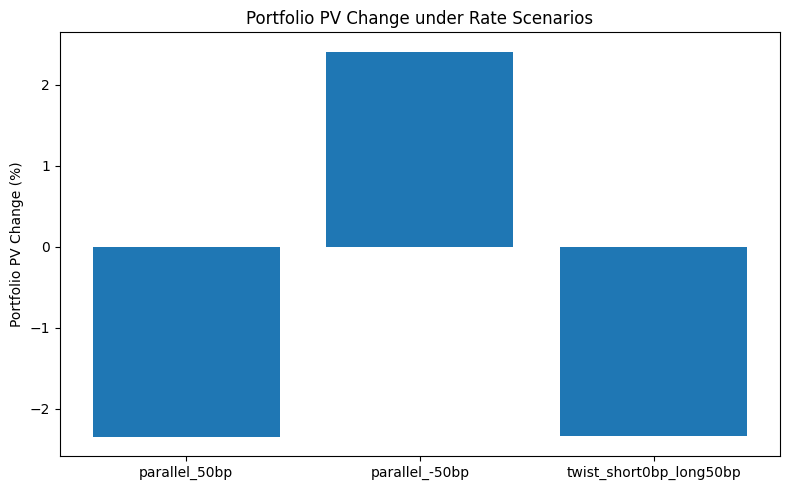

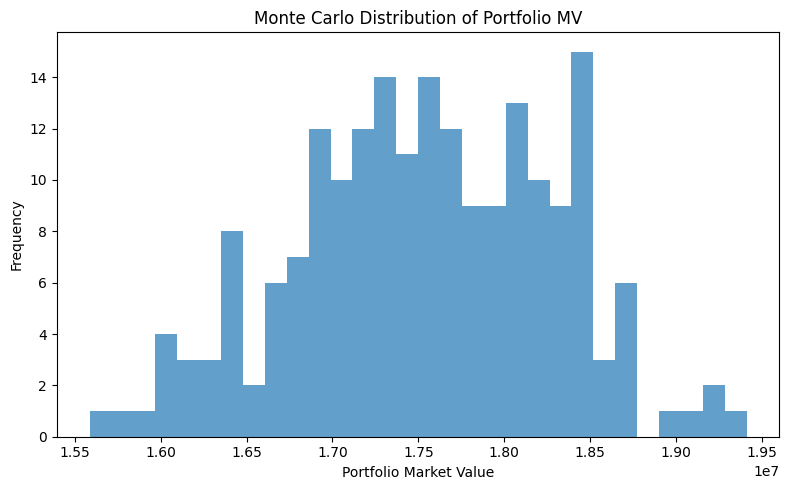

In [ ]:
# interest_rate_risk_simulator_yfinance.py

from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import yfinance as yf

# -----------------------------
# Utilities
# -----------------------------
def year_fraction(start: datetime, end: datetime) -> float:
    """Simple ACT/365 year fraction."""
    return (end - start).days / 365.0

# -----------------------------
# Term structure (yield curve) helper
# -----------------------------
class YieldCurve:
    """
    Term structure object that accepts either a flat rate or a set of (tenor_years -> rate) points.
    Interpolates linearly in year space.
    Rates assumed continuous compounding.
    """
    def __init__(self, points: Optional[Dict[float, float]] = None, flat_rate: Optional[float] = None):
        if flat_rate is None and (points is None or len(points) == 0):
            raise ValueError("Either flat_rate or points must be provided")
        if flat_rate is not None:
            self.flat = True
            self.r = float(flat_rate)
            self._interp = None
        else:
            self.flat = False
            xs = np.array(sorted(points.keys()))
            ys = np.array([points[x] for x in xs])
            self._interp = interp1d(xs, ys, kind='linear', fill_value='extrapolate')

    def rate(self, t: float) -> float:
        if self.flat:
            return self.r
        return float(self._interp(t))

    def discount_factor(self, t: float) -> float:
        r = self.rate(t)
        return math.exp(-r * t)

# -----------------------------
# Bond representation
# -----------------------------
@dataclass
class Bond:
    name: str
    face: float
    coupon_rate: float  # annual coupon rate (e.g., 0.05 for 5%)
    maturity_date: datetime
    coupon_freq: int = 2  # semiannual by default
    issue_date: Optional[datetime] = None
    is_zero: bool = False

    def cashflows(self, as_of: datetime) -> List[Tuple[datetime, float]]:
        if self.is_zero:
            if self.maturity_date > as_of:
                return [(self.maturity_date, self.face)]
            else:
                return []

        # Generate coupon payment dates backward from maturity to after as_of
        payments = []
        period_months = 12 // self.coupon_freq
        payment_dates = []
        cur = self.maturity_date
        while cur > as_of:
            payment_dates.append(cur)
            cur = cur - timedelta(days=period_months*30)  # approx
            if len(payment_dates) > 1000:
                break
        payment_dates = sorted(payment_dates)

        coupon_amount = self.face * self.coupon_rate / self.coupon_freq
        for d in payment_dates[:-1]:
            payments.append((d, coupon_amount))
        if payment_dates:
            # Last payment includes principal + coupon
            payments.append((payment_dates[-1], coupon_amount + self.face))
        return payments

    def clean_price(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv = 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve is not None:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve must be provided")
            pv += amt * df
        return pv

    def macaulay_duration(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv = 0.0
        weighted_sum = 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve is not None:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve must be provided")
            pv_cf = amt * df
            pv += pv_cf
            weighted_sum += t * pv_cf
        if pv == 0:
            return 0.0
        return weighted_sum / pv

    def modified_duration(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        mac_dur = self.macaulay_duration(as_of, ytm=ytm, curve=curve)
        if ytm is not None:
            y = ytm
        else:
            T = year_fraction(as_of, self.maturity_date)
            y = curve.rate(T)
        return mac_dur / (1 + y)

    def convexity(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        cfs = self.cashflows(as_of)
        pv = 0.0
        conv = 0.0
        for d, amt in cfs:
            t = year_fraction(as_of, d)
            if curve is not None:
                df = curve.discount_factor(t)
            elif ytm is not None:
                df = math.exp(-ytm * t)
            else:
                raise ValueError("Either ytm or curve must be provided")
            pv_cf = amt * df
            pv += pv_cf
            conv += t * (t + 1) * pv_cf
        if pv == 0:
            return 0.0
        return conv / pv

    def dv01(self, as_of: datetime, bump: float = 1e-4, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        base_price = self.clean_price(as_of, ytm=ytm, curve=curve)
        if curve is not None:
            if curve.flat:
                bumped_curve = YieldCurve(flat_rate=curve.r + bump)
            else:
                class ShiftedCurve:
                    def __init__(self, base_curve, shift):
                        self.base_curve = base_curve
                        self.shift = shift
                        self.flat = False
                    def rate(self, t):
                        return self.base_curve.rate(t) + self.shift
                    def discount_factor(self, t):
                        return math.exp(-(self.rate(t)) * t)
                bumped_curve = ShiftedCurve(curve, bump)
            bumped_price = self.clean_price(as_of, curve=bumped_curve)
        else:
            bumped_price = self.clean_price(as_of, ytm=ytm + bump)
        return bumped_price - base_price

# -----------------------------
# Portfolio container
# -----------------------------
@dataclass
class Portfolio:
    bonds: List[Tuple[Bond, float]] = field(default_factory=list)  # list of (Bond, position notional)

    def market_value(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        total_mv = 0.0
        for bond, notional in self.bonds:
            price = bond.clean_price(as_of, ytm=ytm, curve=curve)
            position_value = price * (notional / bond.face)
            total_mv += position_value
        return total_mv

    def aggregate_duration_convexity(self, as_of: datetime, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> Dict[str, float]:
        mv = self.market_value(as_of, ytm=ytm, curve=curve)
        dur_sum = 0.0
        conv_sum = 0.0
        for bond, notional in self.bonds:
            price = bond.clean_price(as_of, ytm=ytm, curve=curve)
            pos_mv = price * (notional / bond.face)
            d = bond.modified_duration(as_of, ytm=ytm, curve=curve)
            c = bond.convexity(as_of, ytm=ytm, curve=curve)
            dur_sum += d * pos_mv
            conv_sum += c * pos_mv
        if mv == 0:
            return {"duration": 0.0, "convexity": 0.0}
        return {"duration": dur_sum / mv, "convexity": conv_sum / mv}

    def dv01(self, as_of: datetime, bump: float = 1e-4, ytm: Optional[float] = None, curve: Optional[YieldCurve] = None) -> float:
        base_mv = self.market_value(as_of, ytm=ytm, curve=curve)
        if curve is not None:
            if curve.flat:
                bumped_curve = YieldCurve(flat_rate=curve.r + bump)
            else:
                class ShiftedCurve:
                    def __init__(self, base_curve, shift):
                        self.base_curve = base_curve
                        self.shift = shift
                        self.flat = False
                    def rate(self, t):
                        return self.base_curve.rate(t) + self.shift
                    def discount_factor(self, t):
                        return math.exp(-(self.rate(t)) * t)
                bumped_curve = ShiftedCurve(curve, bump)
            bumped_mv = self.market_value(as_of, curve=bumped_curve)
        else:
            bumped_mv = self.market_value(as_of, ytm=ytm + bump)
        return bumped_mv - base_mv

# -----------------------------
# Scenario engine
# -----------------------------
class ScenarioEngine:
    def __init__(self, base_curve: YieldCurve, as_of: datetime):
        self.base_curve = base_curve
        self.as_of = as_of

    def parallel_shift(self, portfolio: Portfolio, shift_bp: float) -> Dict:
        shift = shift_bp / 10000.0
        if self.base_curve.flat:
            bumped_curve = YieldCurve(flat_rate=self.base_curve.r + shift)
        else:
            class ShiftedCurve:
                def __init__(self, base_curve, shift):
                    self.base_curve = base_curve
                    self.shift = shift
                    self.flat = False
                def rate(self, t):
                    return self.base_curve.rate(t) + self.shift
                def discount_factor(self, t):
                    return math.exp(-(self.rate(t)) * t)
            bumped_curve = ShiftedCurve(self.base_curve, shift)
        base_mv = portfolio.market_value(self.as_of, curve=self.base_curve)
        bumped_mv = portfolio.market_value(self.as_of, curve=bumped_curve)
        return {
            "scenario": f"parallel_{shift_bp}bp",
            "base_mv": base_mv,
            "bumped_mv": bumped_mv,
            "pv_change": bumped_mv - base_mv,
            "pv_change_pct": (bumped_mv - base_mv) / base_mv if base_mv != 0 else 0.0
        }

    def steepen_flatten(self, portfolio: Portfolio, short_shift_bp: float, long_shift_bp: float, pivot_year: float = 2.0) -> Dict:
        s_shift = short_shift_bp / 10000.0
        l_shift = long_shift_bp / 10000.0

        class TwistedCurve:
            def __init__(self, base_curve, s_shift, l_shift, pivot):
                self.base_curve = base_curve
                self.s_shift = s_shift
                self.l_shift = l_shift
                self.pivot = pivot
                self.flat = False
            def rate(self, t):
                if t <= 0:
                    return self.base_curve.rate(0)
                factor = min(1.0, t / self.pivot)
                return self.base_curve.rate(t) + (1 - factor) * self.s_shift + factor * self.l_shift
            def discount_factor(self, t):
                return math.exp(-self.rate(t) * t)

        twisted_curve = TwistedCurve(self.base_curve, s_shift, l_shift, pivot_year)
        base_mv = portfolio.market_value(self.as_of, curve=self.base_curve)
        twisted_mv = portfolio.market_value(self.as_of, curve=twisted_curve)
        return {
            "scenario": f"twist_short{short_shift_bp}bp_long{long_shift_bp}bp",
            "base_mv": base_mv,
            "twisted_mv": twisted_mv,
            "pv_change": twisted_mv - base_mv,
            "pv_change_pct": (twisted_mv - base_mv) / base_mv if base_mv != 0 else 0.0
        }

# -----------------------------
# Vasicek short-rate model for demo Monte Carlo simulation
# -----------------------------
class VasicekSimulator:
    def __init__(self, r0: float, kappa: float, theta: float, sigma: float, dt: float = 1/252):
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.dt = dt

    def simulate_paths(self, n_paths: int, n_steps: int) -> np.ndarray:
        paths = np.zeros((n_paths, n_steps + 1))
        paths[:, 0] = self.r0
        for t in range(1, n_steps + 1):
            z = np.random.normal(size=n_paths)
            dr = self.kappa * (self.theta - paths[:, t-1]) * self.dt + self.sigma * np.sqrt(self.dt) * z
            paths[:, t] = paths[:, t-1] + dr
        return paths

# -----------------------------
# Get Treasury yield curve from yfinance
# -----------------------------
def get_yfinance_treasury_yield_curve() -> Dict[float, float]:
    tickers = {
        0.25: '^IRX',   # 3 months approx
        5.0: '^FVX',    # 5 years
        10.0: '^TNX',   # 10 years
        30.0: '^TYX'    # 30 years
    }

    points = {}
    for years, ticker in tickers.items():
        data = yf.Ticker(ticker).history(period='5d')
        if data.empty:
            continue
        latest_rate = data['Close'][-1] / 100  # convert % to decimal
        cc_rate = np.log(1 + latest_rate)
        points[years] = cc_rate

    # Approximate 2Y by linear interpolation between 3M and 5Y
    if 0.25 in points and 5.0 in points:
        points[2.0] = points[0.25] + (points[5.0] - points[0.25]) * (2.0 - 0.25) / (5.0 - 0.25)

    print("Using Treasury yield curve points from yfinance:", points)
    return points

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    today = datetime.today()

    # Load yield curve from yfinance
    points = get_yfinance_treasury_yield_curve()
    base_curve = YieldCurve(points=points)

    # Create sample bonds
    b1 = Bond(name='UST_5Y', face=1000, coupon_rate=0.03, maturity_date=today + timedelta(days=int(5*365)), coupon_freq=2, issue_date=today - timedelta(days=30))
    b2 = Bond(name='CORP_7Y', face=1000, coupon_rate=0.045, maturity_date=today + timedelta(days=int(7*365)), coupon_freq=2, issue_date=today - timedelta(days=30))
    b3 = Bond(name='ZERO_2Y', face=1000, coupon_rate=0.0, maturity_date=today + timedelta(days=int(2*365)), coupon_freq=1, is_zero=True)

    portfolio = Portfolio(bonds=[(b1, 10_000_000), (b2, 5_000_000), (b3, 2_000_000)])

    # Portfolio analytics at base curve
    base_mv = portfolio.market_value(today, curve=base_curve)
    agg = portfolio.aggregate_duration_convexity(today, curve=base_curve)
    dv01 = portfolio.dv01(today, curve=base_curve)

    print(f"Base Market Value: {base_mv:,.2f}")
    print(f"Aggregate Duration: {agg['duration']:.4f}")
    print(f"Aggregate Convexity: {agg['convexity']:.4f}")
    print(f"Portfolio DV01: {dv01:,.2f}")

    # Scenario analysis
    scenario_engine = ScenarioEngine(base_curve, today)
    scenarios = []
    scenarios.append(scenario_engine.parallel_shift(portfolio, 50))
    scenarios.append(scenario_engine.parallel_shift(portfolio, -50))
    scenarios.append(scenario_engine.steepen_flatten(portfolio, short_shift_bp=0, long_shift_bp=50))

    df_scenarios = pd.DataFrame(scenarios)
    print("\nScenario Results:")
    print(df_scenarios)

    # Save scenario results
    df_scenarios.to_csv('scenario_results.csv', index=False)
    print("\nSaved scenario_results.csv")

    # Plot PV changes %
    plt.figure(figsize=(8,5))
    plt.bar(df_scenarios['scenario'], df_scenarios['pv_change_pct'] * 100)
    plt.ylabel('Portfolio PV Change (%)')
    plt.title('Portfolio PV Change under Rate Scenarios')
    plt.tight_layout()
    plt.savefig('pv_changes.png')
    print("Saved pv_changes.png")

    # Vasicek Monte Carlo simulation demo
    vasicek = VasicekSimulator(r0=0.03, kappa=0.15, theta=0.035, sigma=0.01, dt=1/252)
    n_paths = 200
    n_steps = 252  # 1 year daily steps
    paths = vasicek.simulate_paths(n_paths, n_steps)

    mc_values = []
    for i in range(n_paths):
        r_sim = paths[i, -1]
        sim_curve = YieldCurve(flat_rate=float(r_sim))
        mv_sim = portfolio.market_value(today, curve=sim_curve)
        mc_values.append(mv_sim)

    mc_values = np.array(mc_values)
    print("\nMonte Carlo Simulation Results (Vasicek Model):")
    print(f"Mean Portfolio MV: {mc_values.mean():,.2f}")
    print(f"Std Dev Portfolio MV: {mc_values.std():,.2f}")

    plt.figure(figsize=(8,5))
    plt.hist(mc_values, bins=30, alpha=0.7)
    plt.xlabel('Portfolio Market Value')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Distribution of Portfolio MV')
    plt.tight_layout()
    plt.savefig('mc_portfolio_mv_histogram.png')
    print("Saved mc_portfolio_mv_histogram.png")

